### Análisis y Procesamiento de Señales - 2do Cuatrimestre 2025
# **Tarea Semanal 8**: *Filtrado digital lineal de ECG*
#### Mora Taranilla y Victoria Jazmín Salgado

## **Resumen**
Esta tarea semanal se enfoca en el diseño y aplicación de filtros digitales. Se realizó una plantilla definida por el ancho de banda de la señal de un electrocardiograma y posteriormente se llevó a cabo el filtrado de la señal a partir de filtros IIR y FIR. 

## **Introducción Teórica**

Dentro de los filtros digitales, se pueden encontrar aquellos que tienen una respuesta al impulso finita (FIR) o infinita (IIR). A continuación se exponen sus principales diferencias.

### Filtros FIR
Un filtro FIR no cuenta con recursividad, es decir, los coeficientes $a_i$ del sistema son cero menos en caso de $a_0$, donde el valor es igual a 1. De esta forma, el filtro se puede representar, en forma de ecuaciones en diferencias de la siguiente manera:

$$
y[n] = \sum_{k=0}^{N-1} b_k \cdot x[n-k]
$$

Siendo N la longitud del vector de coeficientes $b_i$. En este caso, la sumatoria comienza en cero ya que se trabaja sobre señales causales.

Se clasifican los mismos en cuatro tipos, que dependen de la simetría de la respuesta al impulso (par o impar) y la longitud de la misma (par o impar). De esta forma se definen:

- Tipo I: Simetría par y longitud impar.
- Tipo II: Simetría par y longitud par.
- Tipo III: Simetría impar y longitud impar.
- Tipo IV: Simetría impar y longitud par.

Los filtros FIR cuentan con muchas ventajas, entre ellas que los mismos son siempre estables, ya que los polos se encuentran únicamente en el origen y que en su mayoría cuentan con una fase lineal. Para llevar a cabo un filtro FIR hay tres métodos principales: método de ventanas, método de cuadrados mínimos y método de Parks-McClellan. 

### Filtros IIR

La **ecuación en diferencias** causal general de un filtro IIR (normalizada con $a_0 = 1$) es

$$
y[n] = \sum_{k=0}^{N} b_k\,x[n-k] \;-\; \sum_{k=1}^{M} a_k\,y[n-k] , \qquad n\in\mathbb{Z}
$$

La ventaja de este tipo de filtros, frente a los FIR descritos anteriormente, es que pueden cumplir con especificaciones pedidas con un orden menor que el filtro FIR equivalente, lo que resulta en menor costo computacional y mayor velocidad .

El uso de filtros en este trabajo será necesario para mitigar los efectos que tendrá el ruido proveniente de diversas fuentes sobre la señal que se desea estudiar, en este caso una ECG
- Ruido causado por el movimiento de los electrodos (alta frecuencia)
- Ruido muscular (alta frecuencia)
- Movimiento de la  línea de base del ECG (baja frecuencia)

## **Desarrollo del Trabajo**
En primer lugar, se llevó a cabo el diseño de la plantilla para el filtrado de la señal de ECG. Esta se realizó en base a una estimación del ancho de banda de la misma. 

Una vez que se contó con la plantilla de diseño de los filtros, se prodeció al filtrado de la señal implementando tanto filtros IIR como FIR.

**FILTROS IIR:**
Se utilizaron los siguientes filtros IIR:
- Butterworth (planicidad máxima)
- Chebyschev (I y II)
- Cauer (Elliptic)

In [51]:
import numpy as np
import matplotlib.pyplot as plt
from scipy import signal
import scipy.io as sio
from pytc2.sistemas_lineales import plot_plantilla

In [52]:
# Plantilla de diseño 
# pasabanda digital 

fs = 1000 #[Hz]
wp = [1, 35] #comienzo y fin banda de paso
ws = [0.01, 40]  #banda de stop [Hz]

#transicion en pocos hz implica orden mas elevado del polinomio 
 
alpha_p = 1 #atenuacion maxima a la wp, alpha max o pérdidas en banda de paso (dB)
alpha_s = 40 #atenuacion minima a la ws, alpha min o minima atenuacion requerida en banda de paso (dB)

Se comienza por importar la señal de ECG a filtrar, y se grafica a continuación para obtener una visión general de la  misma. De esta manera es posible observar a simple vista el movimiento de la línea de base, ya que la señal se ve montada sobre baja frecuencia. 

In [53]:
fs_ecg = 1000 # Hz

sio.whosmat('ECG_TP4.mat')
mat_struct = sio.loadmat('./ECG_TP4.mat')

ecg_one_lead = mat_struct['ecg_lead'].squeeze()
N = len(ecg_one_lead)

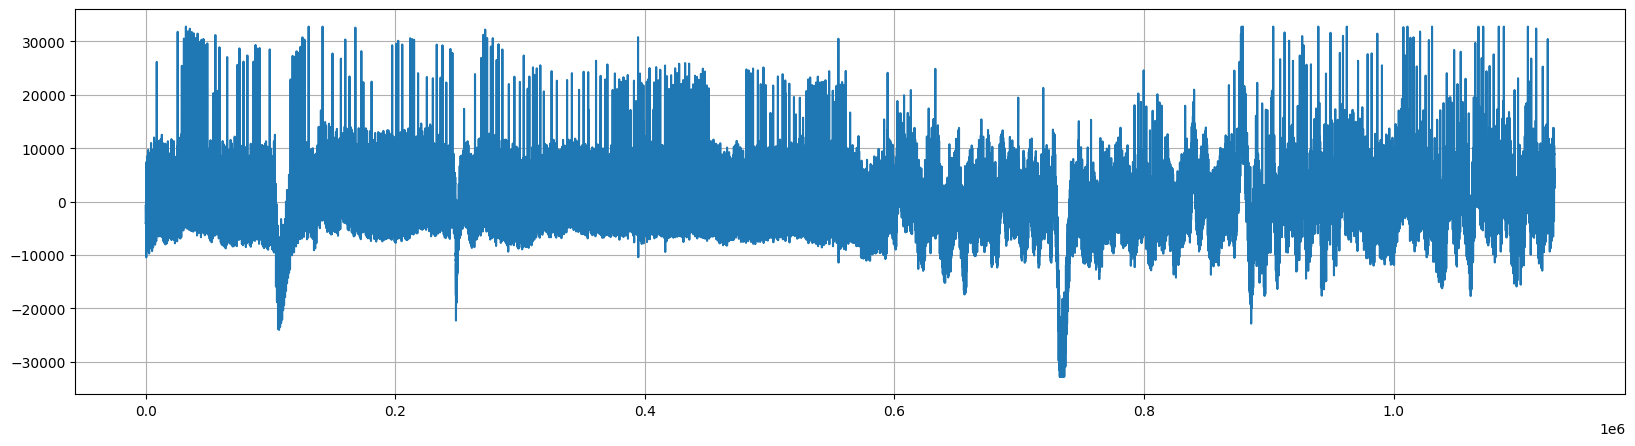

In [54]:
plt.figure(figsize=(20,5))
plt.plot(ecg_one_lead)
plt.grid(True)

Luego se diseñan los filtros IIR, utilizando la funcion de scipy *iirdesign*. Esta función utiliza los parámetros definidos en la plantilla de diseño, y devuelve las secciones bicuadráticas necesarias para la implementación del filtro. 

In [55]:
f_aprox = 'butter'
mi_sos_butter = signal.iirdesign(wp=wp, ws=ws, gpass=alpha_p, gstop=alpha_s, analog=False, ftype=f_aprox, output='sos', fs=fs)

f_aprox = 'cheby1'
mi_sos_cheby1 = signal.iirdesign(wp=wp, ws=ws, gpass=alpha_p, gstop=alpha_s, analog=False, ftype=f_aprox, output='sos', fs=fs)

f_aprox = 'cheby2'
mi_sos_cheby2 = signal.iirdesign(wp=wp, ws=ws, gpass=alpha_p, gstop=alpha_s, analog=False, ftype=f_aprox, output='sos', fs=fs)

f_aprox = 'cauer'
mi_sos_cauer = signal.iirdesign(wp=wp, ws=ws, gpass=alpha_p, gstop=alpha_s, analog=False, ftype=f_aprox, output='sos', fs=fs)

Se sigue por aplicar los filtros diseñados sobre la señal ECG. 
Para poder asegurar una respuesta de fase lineal se implementa el filtro bidireccionalmnete (utilizando *sosfiltfilt*). Esto es de suma importancia en este tipo de señales, ya que de esta manera se tendrá un retardo constante para toda las frecuencias. Así será posible preservar la forma y el alineamiento de las ondas. 

In [56]:
ecg_filt_butter = signal.sosfiltfilt(mi_sos_butter, ecg_one_lead)
ecg_filt_cauer = signal.sosfiltfilt(mi_sos_cauer, ecg_one_lead)
ecg_filt_cheby1 = signal.sosfiltfilt(mi_sos_cheby1, ecg_one_lead)
ecg_filt_cheby2 = signal.sosfiltfilt(mi_sos_cheby2, ecg_one_lead)

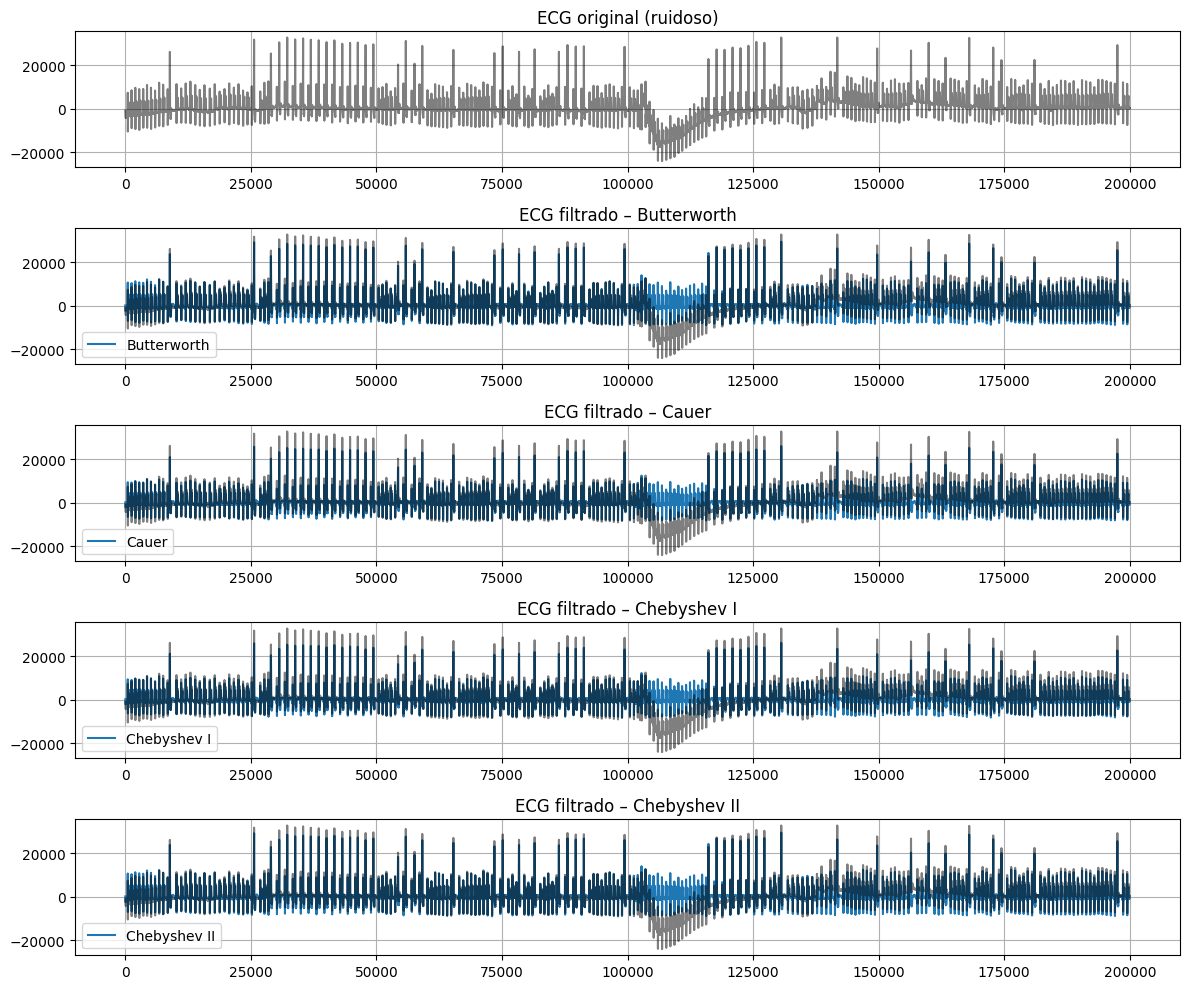

In [57]:
#panorama general mas muestras

plt.figure(figsize=(12,10))

# Señal original
plt.subplot(5,1,1)
plt.plot(ecg_one_lead[:200000], color='k', alpha=0.5)
plt.title('ECG original (ruidoso)')
plt.grid(True)

# Butterworth
plt.subplot(5,1,2)
plt.plot(ecg_filt_butter[:200000], label='Butterworth')
plt.plot(ecg_one_lead[:200000], color='k', alpha=0.5)
plt.title('ECG filtrado – Butterworth')
plt.legend()
plt.grid(True)

# Cauer / Elliptic
plt.subplot(5,1,3)
plt.plot(ecg_filt_cauer[:200000], label='Cauer')
plt.plot(ecg_one_lead[:200000], color='k', alpha=0.5)
plt.title('ECG filtrado – Cauer')
plt.legend()
plt.grid(True)

# Chebyshev I
plt.subplot(5,1,4)
plt.plot(ecg_filt_cheby1[:200000], label='Chebyshev I')
plt.plot(ecg_one_lead[:200000], color='k', alpha=0.5)
plt.title('ECG filtrado – Chebyshev I')
plt.legend()
plt.grid(True)

# Chebyshev II
plt.subplot(5,1,5)
plt.plot(ecg_filt_cheby2[:200000], label='Chebyshev II')
plt.plot(ecg_one_lead[:200000], color='k', alpha=0.5)
plt.title('ECG filtrado – Chebyshev II')
plt.legend()
plt.grid(True)

plt.tight_layout()
plt.show()


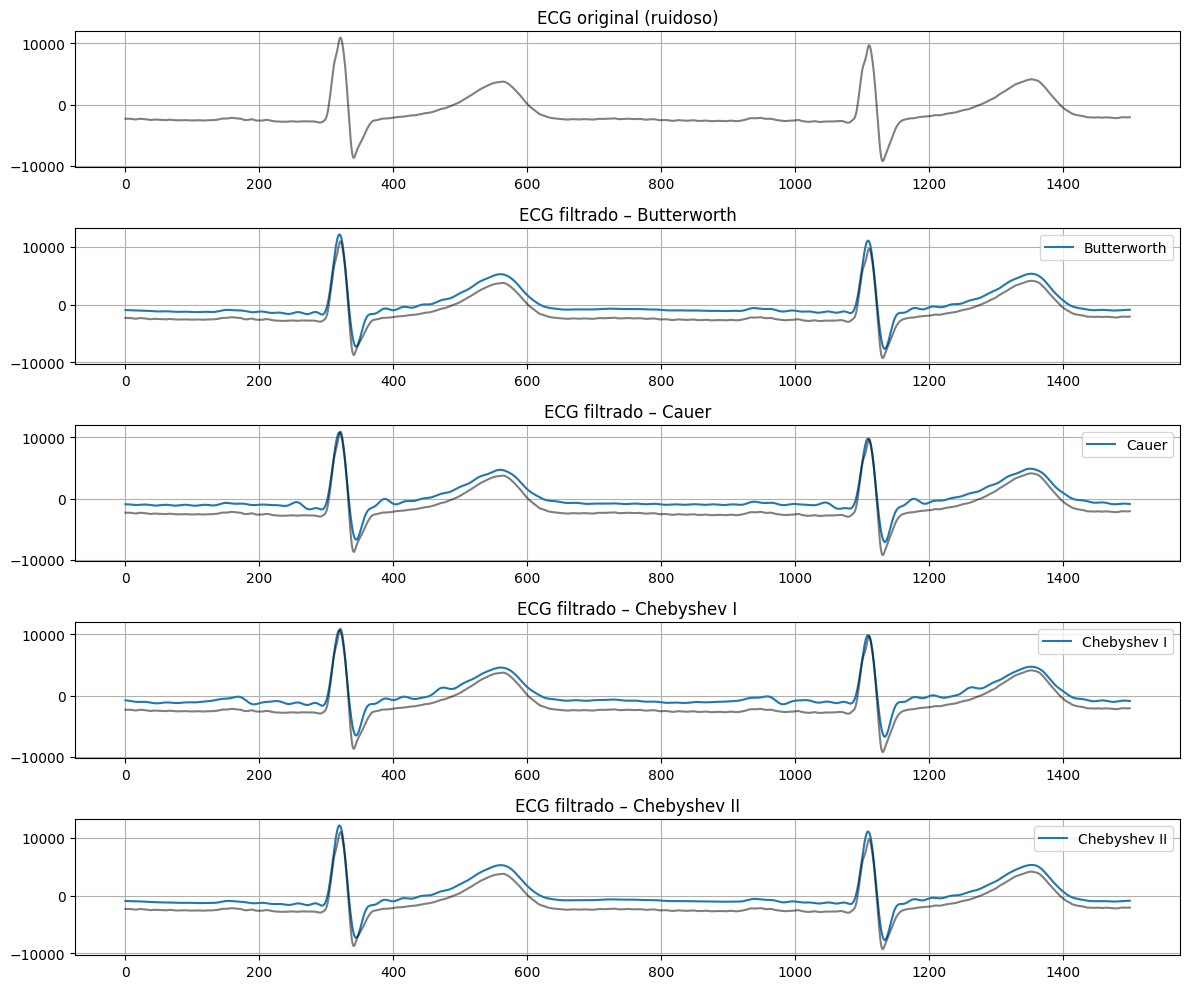

In [58]:
#Región de interés 1 [4000:5500] - zona no ruidosa

plt.figure(figsize=(12,10))

# Señal original
plt.subplot(5,1,1)
plt.plot(ecg_one_lead[4000:5500], color='k', alpha=0.5)
plt.title('ECG original (ruidoso)')
plt.grid(True)

# Butterworth
plt.subplot(5,1,2)
plt.plot(ecg_filt_butter[4000:5500], label='Butterworth')
plt.plot(ecg_one_lead[4000:5500], color='k', alpha=0.5)
plt.title('ECG filtrado – Butterworth')
plt.legend()
plt.grid(True)

# Cauer / Elliptic
plt.subplot(5,1,3)
plt.plot(ecg_filt_cauer[4000:5500], label='Cauer')
plt.plot(ecg_one_lead[4000:5500], color='k', alpha=0.5)
plt.title('ECG filtrado – Cauer')
plt.legend()
plt.grid(True)

# Chebyshev I
plt.subplot(5,1,4)
plt.plot(ecg_filt_cheby1[4000:5500], label='Chebyshev I')
plt.plot(ecg_one_lead[4000:5500], color='k', alpha=0.5)
plt.title('ECG filtrado – Chebyshev I')
plt.legend()
plt.grid(True)

# Chebyshev II
plt.subplot(5,1,5)
plt.plot(ecg_filt_cheby2[4000:5500], label='Chebyshev II')
plt.plot(ecg_one_lead[4000:5500], color='k', alpha=0.5)
plt.title('ECG filtrado – Chebyshev II')
plt.legend()
plt.grid(True)

plt.tight_layout()
plt.show()

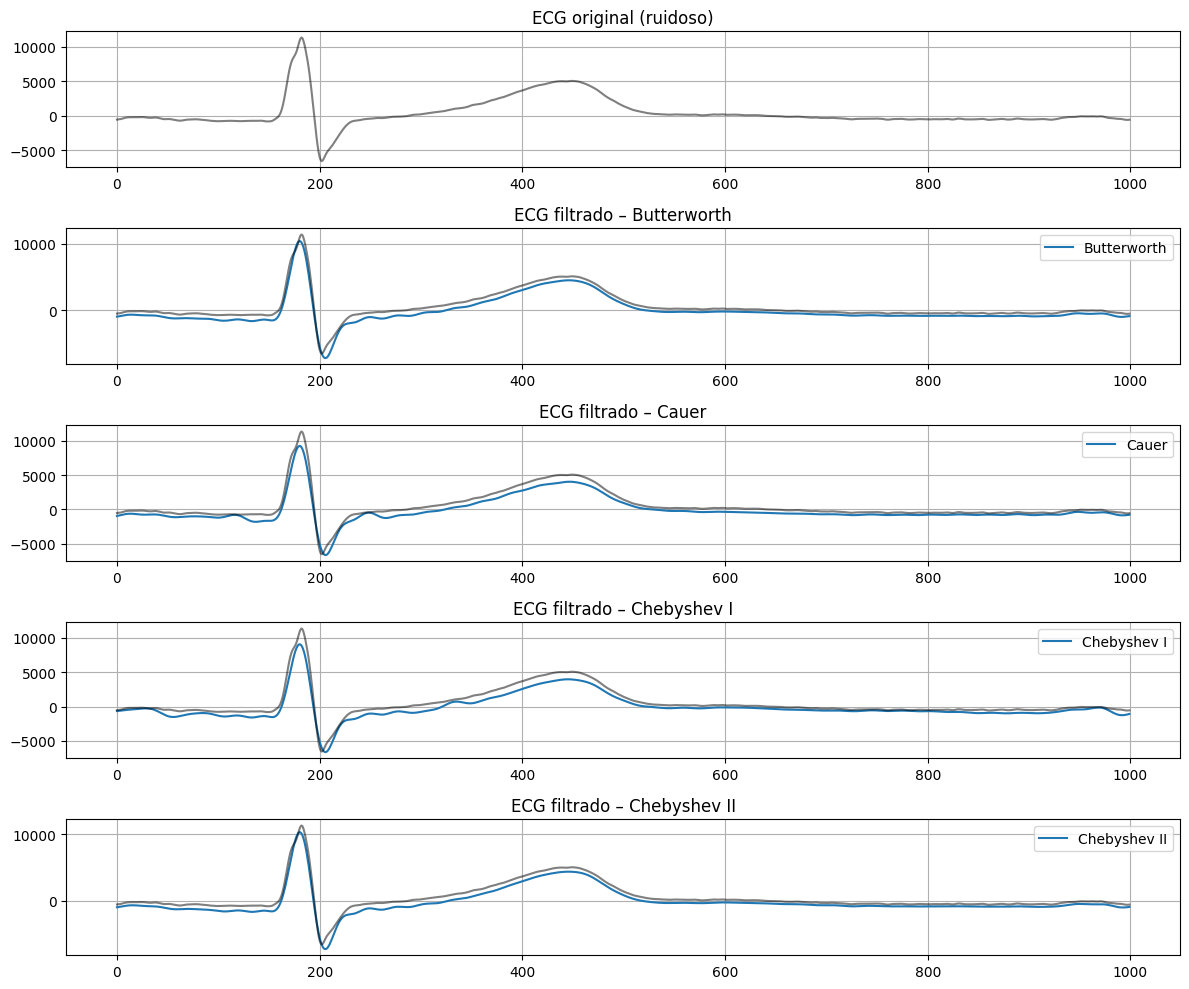

In [59]:
#Región de interés 2 [10e3, 11e3] - zona no ruidosa

plt.figure(figsize=(12,10))

# Señal original
plt.subplot(5,1,1)
plt.plot(ecg_one_lead[10000 : 11000], color='k', alpha=0.5)
plt.title('ECG original (ruidoso)')
plt.grid(True)

# Butterworth
plt.subplot(5,1,2)
plt.plot(ecg_filt_butter[10000 : 11000], label='Butterworth')
plt.plot(ecg_one_lead[10000 : 11000], color='k', alpha=0.5)
plt.title('ECG filtrado – Butterworth')
plt.legend()
plt.grid(True)

# Cauer / Elliptic
plt.subplot(5,1,3)
plt.plot(ecg_filt_cauer[10000 : 11000], label='Cauer')
plt.plot(ecg_one_lead[10000 : 11000], color='k', alpha=0.5)
plt.title('ECG filtrado – Cauer')
plt.legend()
plt.grid(True)

# Chebyshev I
plt.subplot(5,1,4)
plt.plot(ecg_filt_cheby1[10000 : 11000], label='Chebyshev I')
plt.plot(ecg_one_lead[10000 : 11000], color='k', alpha=0.5)
plt.title('ECG filtrado – Chebyshev I')
plt.legend()
plt.grid(True)

# Chebyshev II
plt.subplot(5,1,5)
plt.plot(ecg_filt_cheby2[10000 : 11000], label='Chebyshev II')
plt.plot(ecg_one_lead[10000 : 11000], color='k', alpha=0.5)
plt.title('ECG filtrado – Chebyshev II')
plt.legend()
plt.grid(True)

plt.tight_layout()
plt.show()

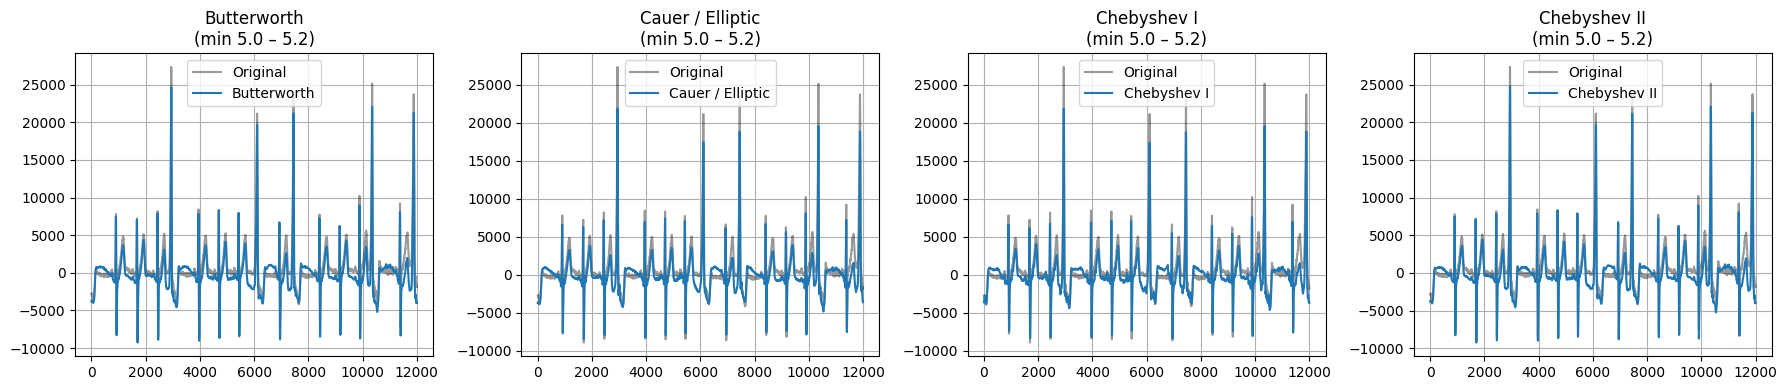

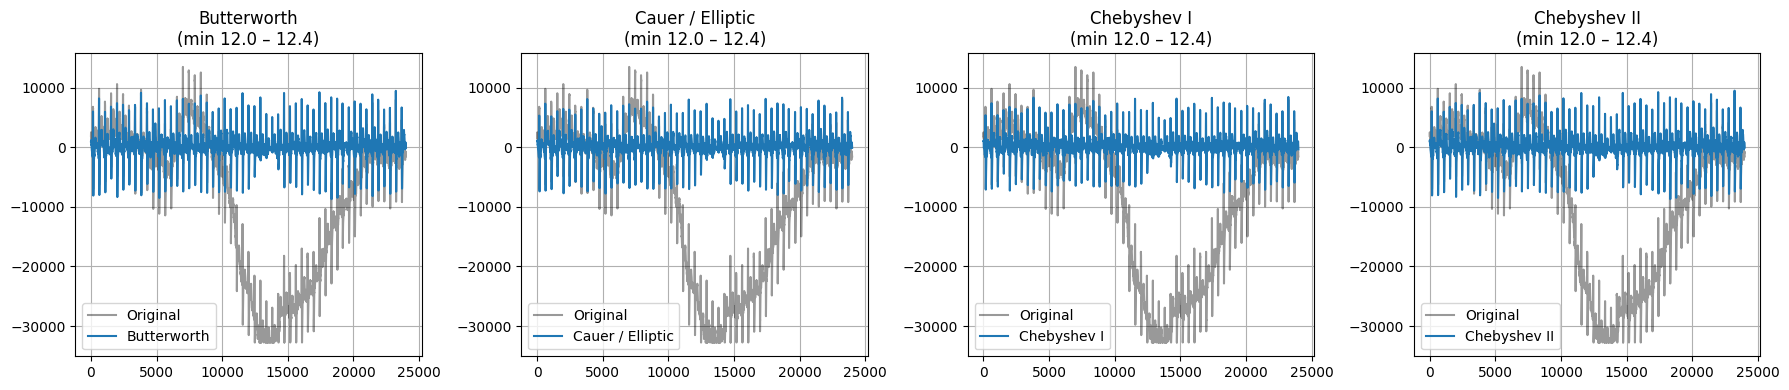

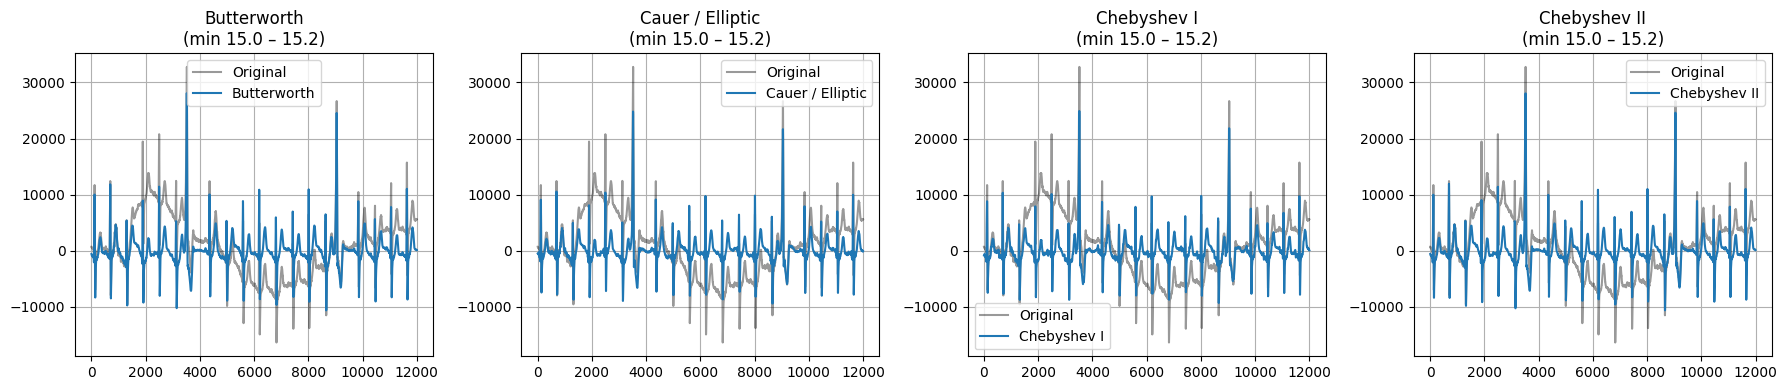

In [61]:
# Regiones de interés RUIDOSAS en minutos → muestras
regs_interes = (
    np.array([5, 5.2])  * 60 * fs,
    np.array([12, 12.4]) * 60 * fs,
    np.array([15, 15.2]) * 60 * fs,
)

regs_interes = [(int(a), int(b)) for a, b in regs_interes]

filtros = [
    (ecg_filt_butter, "Butterworth"),
    (ecg_filt_cauer,  "Cauer / Elliptic"),
    (ecg_filt_cheby1, "Chebyshev I"),
    (ecg_filt_cheby2, "Chebyshev II"),
]

for (i0, i1) in regs_interes:
    
    plt.figure(figsize=(18,4))

    for j, (filt, nombre) in enumerate(filtros, start=1):

        plt.subplot(1, 4, j)
        plt.plot(ecg_one_lead[i0:i1], color='k', alpha=0.4, label="Original")
        plt.plot(filt[i0:i1], label=nombre)
        plt.title(f"{nombre}\n(min {i0/(fs*60):.1f} – {i1/(fs*60):.1f})")
        plt.grid(True)
        plt.legend()

    plt.tight_layout()
    plt.show()